<a href="https://colab.research.google.com/github/breezingit/MNIST-Classification-using-Pytorch/blob/main/MNIST_pytorch_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using a Linear Model where we simply multiply weights with the parameters and add bias shows only linear relationship between the features and the results. This is definitely not the case because the model will not be able to correctly determine the digits once the image is slighly tilted or even when there is little distortion.
<br>
So this model will use the same linear layer with differnt number of outputs but also use a hidden layer. This hidden layer will then pass on the new featues after applying an activation function(ReLu here) which gives us a non-linear relationship between the features and the labels. Hence the model will becomce more powerful.

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [ ]:
dataset = MNIST(root='/data', download= True)

In [ ]:
test_dataset=MNIST(root='data/', train = False, download= True)

In [ ]:
import torchvision.transforms as transforms

In [ ]:
dataset = MNIST(root='/data', train = True, transform =  transforms.ToTensor())

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds= random_split(dataset, [50000, 10000])
len(train_ds),len(val_ds)


(50000, 10000)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle= True)
val_loader = DataLoader(val_ds, batch_size, shuffle= True)

In [ ]:
for images, labels in train_loader:
  print("images.shape: ", images.shape)
  inputs = images.reshape(-1, 784)
  print("inputs.shape, ", inputs.shape)
  break

images.shape:  torch.Size([128, 1, 28, 28])
inputs.shape,  torch.Size([128, 784])


In [ ]:
input_size= inputs.shape[-1]
hidden_size = 32

In [ ]:
import torch.nn as nn
layer1= nn.Linear(input_size, hidden_size)

In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
layer1_outputs=layer1(inputs)
print('layer 1 outputs: ', layer1_outputs.shape)

layer 1 outputs:  torch.Size([128, 32])


In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
import torch.nn.functional as F
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
input_size= 784
hidden_size= 32
num_classes= 10

In [ ]:
model= MnistModel(input_size, hidden_size, out_size= num_classes)

In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
  outputs = model(images)
  loss= F.cross_entropy(outputs, labels)
  print('Loss: ', loss.item())
  break


Loss:  2.3002753257751465


## Connecting to the GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.device('cuda')


device(type='cuda')

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  

In [ ]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
## a pytorch data loader for moving the batches of data automatically to the GPU

class DeviceDataLoader():
  def __init__(self, dl, device):
      self.dl = dl
      self.device= device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
    
  def __len__(self):
    return len(self.dl)

In [ ]:
# sending data and val loader to the GPU

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Training the Model
## using Gradient Descent
First you tell the optimizer what parameters it should be updating. Done by<br>
`opt_function(model.parameters(),lr)`
<br>

The gradients are stored by the tensors once the `loss.backward()` function is called.
<br>
`optimizer.step()` then uses these gradients to OPTIMIZE the values of the parameters.
<br>

Finally make the gradients zero using `optimizer.zero_grad()` {otherwise the old and new gradients will be added together}

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = MnistModel(input_size, hidden_size, out_size= num_classes)

#send model to GPU as well
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2651, val_acc: 0.9215
Epoch [1], val_loss: 0.1881, val_acc: 0.9448
Epoch [2], val_loss: 0.1529, val_acc: 0.9582
Epoch [3], val_loss: 0.1669, val_acc: 0.9517
Epoch [4], val_loss: 0.1368, val_acc: 0.9612


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1286, val_acc: 0.9629
Epoch [1], val_loss: 0.1216, val_acc: 0.9656
Epoch [2], val_loss: 0.1265, val_acc: 0.9627
Epoch [3], val_loss: 0.1193, val_acc: 0.9663
Epoch [4], val_loss: 0.1187, val_acc: 0.9665


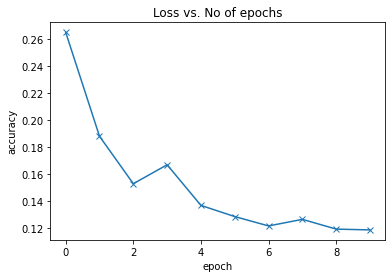

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Loss vs. No of epochs');


In [ ]:
from torchvision.transforms import ToTensor
test_dataset = MNIST(root='/data', train= False, transform= ToTensor())

In [ ]:
def predict_image(img, model):
  ## unsqueeze converts image of size (1,28,28) to (1,1,28,28) because we need
  ## a batch of images for the model and this is just one image
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 7 , Predicted:  7


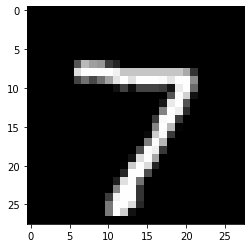

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap= 'gray')
print('Label:', label, ', Predicted: ', predict_image(img, model))

Label: 6 , Predicted:  6


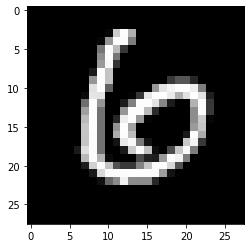

In [ ]:
img, label = test_dataset[11]
plt.imshow(img[0], cmap= 'gray')
print('Label:', label, ', Predicted: ', predict_image(img, model))

##Final Score of the Model on the testing dataset

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.968554675579071, 'val_loss': 0.10644277185201645}